# TASK 1 :Predict Restaurant Ratings

## Objective
Build a machine learning model to predict the aggregate rating of a restaurant based on other features.



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# Load the dataset
data = pd.read_csv('dataset.csv')

# Fill missing values in 'Cuisines' with 'Unknown'
data['Cuisines'].fillna('Unknown', inplace=True)

# Separate features and target variable
X = data.drop(columns=['Aggregate rating'])
y = data['Aggregate rating']

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), X.select_dtypes(exclude=['object']).columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the regression models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42)
}

# Train and evaluate the models
results = {}

for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[model_name] = {'MSE': mse, 'R2': r2}
    
    print(f"{model_name} - MSE: {mse}, R2: {r2}")

# Analyze the most influential features for the best model
best_model_name = max(results, key=lambda k: results[k]['R2'])
best_model = models[best_model_name]

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', best_model)])
pipeline.fit(X_train, y_train)

# Extract feature importances (for Decision Tree) or coefficients (for Linear Regression)
if best_model_name == 'Decision Tree Regression':
    feature_importances = pipeline.named_steps['model'].feature_importances_
    feature_names = (pipeline.named_steps['preprocessor']
                     .transformers_[1][1]
                     .get_feature_names_out(categorical_columns))
    feature_names = list(X.select_dtypes(exclude=['object']).columns) + list(feature_names)
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
else:
    coefficients = pipeline.named_steps['model'].coef_
    feature_names = (pipeline.named_steps['preprocessor']
                     .transformers_[1][1]
                     .get_feature_names_out(categorical_columns))
    feature_names = list(X.select_dtypes(exclude=['object']).columns) + list(feature_names)
    importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    importance_df = importance_df.sort_values(by='Coefficient', ascending=False)

print(importance_df.head(10))


Linear Regression - MSE: 1.757431522123442, R2: 0.22787901211862305
Decision Tree Regression - MSE: 0.04956043956043955, R2: 0.9782258056308187
                       Feature  Importance
6                        Votes    0.898963
17169      Rating color_Orange    0.051526
17177         Rating text_Poor    0.022198
17175         Rating text_Good    0.013084
17178    Rating text_Very Good    0.002580
0                Restaurant ID    0.002237
2                    Longitude    0.001359
3                     Latitude    0.001120
4         Average Cost for two    0.000836
17163  Has Online delivery_Yes    0.000141


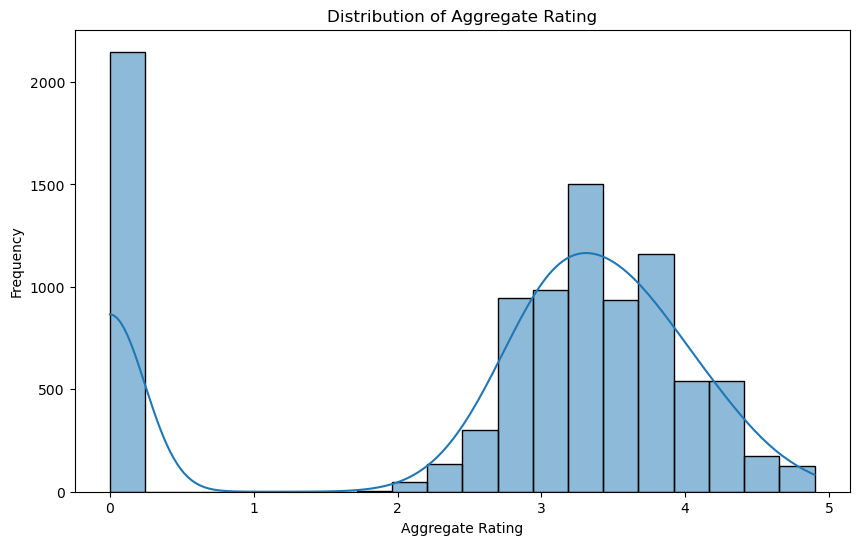

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data['Aggregate rating'], bins=20, kde=True)
plt.title('Distribution of Aggregate Rating')
plt.xlabel('Aggregate Rating')
plt.ylabel('Frequency')
plt.show()
